# Introduction

In our in-class discussion last time, we spent a lot of time talking about how there are many unmeasured factors that can contribute to variation in walking speed. So we should expect our data to have a lot of noise. I think that's perfectly right. However, I countered by suggesting that what a lot of statistical tools (like t-tests) do is allow us to partition out the noise part of the data from the causal influence of behavioral priming. That's a remarkable claim if you think about it. All we have is just data on walking speeds - how are we supposed to know what parts of the data are noise and what parts are causal effects? The point of this lecture is to understand the theory behind normal distributions and how they help us routinely overcome this problem.

# What is noise?

Here's a natural thought about the Bargh experiment: what if the apparent result is just causes by other variables we haven't measured? Some people might have showed up to the experiment sleepy. They'll walk slow. Others might be late for their next class. They'll hurry down the hallway. Other people are simply tall and their natural stride tends to be quite quick. If you split a group of 30 people into two groups, there is a good chance some of these factors will be unbalanced. One group will tend to walk faster than the other, just by the nature of random assignment. Priming might have nothing to do with it.

If we drew a picture of all the causal relationships potentially involved, we might have something like this:

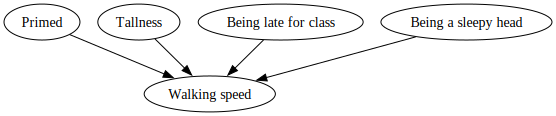

In [27]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from graphviz import Digraph

G = Digraph()

G.node("a",'Primed') # generate a node "a", label it "primed" and add it to the graph named dot
G.node("b",'Walking speed')
G.node("n","Tallness")
G.node("k","Being late for class")
G.node("j","Being a sleepy head")

G.edges(['ab']) # connect node a to node b
G.edges(['nb']) # connect node n to node b
G.edges(['kb'])
G.edges(['jb'])
G

I've introduce a new package, `graphviz`. It will serve an extremely narrow purpose - making little circle and arrow diagrams. The methods I've used above are all the methods we'll use in this package. So it doesn't add much to learn. We can tinker with the aesthetics here and there but that's not imperative.

They diagrams are called causal graphs. They have a bunch of special properties but we'll save them for latter in the term. For now, your intuitions about how they work are good enough for us. Each node represents a variable. The arrows represent the effect of that variable on another variable.

I want to demonstrate to you that Bayesian inference can help us estimate the size of the causal effect even in noisy environments. We'll use a familiar strategy - we'll simulate data in an environment where we know the correct answer. Then we'll see if the model we built last class can make the right inferences. In our case, we'll assume that the causal effect of priming is 1 second - if you are primed, you walk 1 second slower than you would otherwise. In the rest of the simulation, I'll generate random values for the noise variables: tallness, lateness, sleepiness. We'll give each of them small effects on the walking speed. So we can generate 15 observations for the control group:

In [24]:
tallness = stats.norm(170,10).rvs(15)
late = np.random.choice([0,1],size=15)
sleepy = np.random.choice([0,1],size=15)

control_speed = 8 - 0.01 * tallness - 0.5 * late + 0.4 * sleepy

And 15 more for the control group. The code is identical except I've added 1 second of slowness for the primed folks.

In [23]:
tallness = stats.norm(170,10).rvs(15)
late = np.random.choice([0,1],size=15)
sleepy = np.random.choice([0,1],size=15)

speed = 8 - 0.01 * tallness - 0.5 * late + 0.4 * sleepy
primed_speed = speed + 1

Visually, here is what our simulated data looks like.

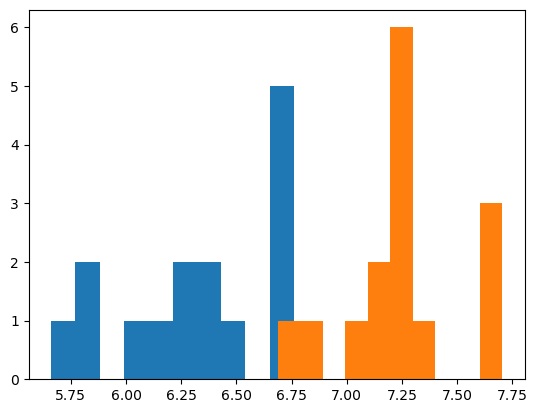

In [25]:
plt.hist(control_speed,alpha=1,color="tab:blue")
plt.hist(primed_speed,alpha=1,color="tab:orange");

Fit the pymc model.

In [21]:
with pm.Model() as m0:
    m0 = pm.Normal('mean_g0',10,5)
    m1 = pm.Normal('mean_g1',10,5)
    std = pm.Gamma('std',3,1) 
    
    y0 = pm.Normal('y0',m0,std,observed=primed_speed)
    y1 = pm.Normal('y1',m1,std,observed=control_speed)

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_g0, mean_g1, std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


And visualize the estimated difference in average walking speed. What do you know - it looks like the primed folks take about 1 second longer to walk down the hallway.

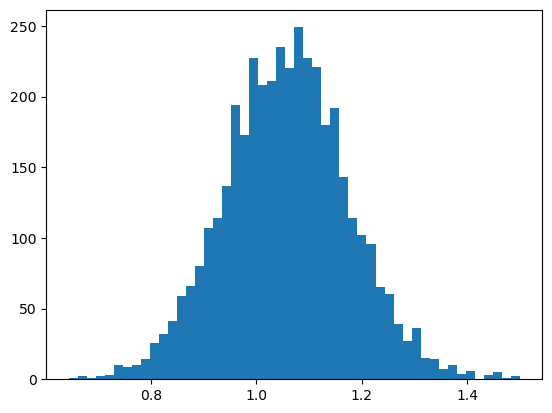

In [22]:
diffs = trace.posterior['mean_g0'].values.flatten() - trace.posterior['mean_g1'].values.flatten()
plt.hist(diffs,bins=50);

This demonstrates the method can detect an effect when it is there. But we might ask two follow up questions:
1. What if there was A LOT more noise? Would we still detect an effect?
2. What if there wasn't effect (primed group doesn't get a 1 second bump), would Bayesian inference mislead us?

Stop at this point and adjust the simulations to explore those questions.

# What do we mean when we say something is normally distributed?

Across all kinds of scientific fields and all kinds of studies, people assume their data are normally distributed. Sometimes they say it explicitly. But usually it is implicit in the choice of statistical tools. t-tests, regressions, ANOVA are all technical terms you often seen in psychology papers. Each of these instruments makes normality assumptions at various places. But interpreting the claim that the "data are normally distributed" is surprisingly hard. On first glance, real life data are almost never actually normally distributed. Let me show you a simple example. Here is the data from the bargh experiment we discussed last time.

In [2]:
url = 'https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/bargh_experiment_2_data'

data = pd.read_csv(url)
data

,group,speeds
0,0.0,9.610
1,0.0,7.110
2,0.0,7.880
3,0.0,7.380
4,0.0,7.050
5,0.0,8.510
6,0.0,8.260
7,0.0,8.680
8,0.0,7.860
9,0.0,9.020


In [4]:
control = data[data.group == 1]
primed = data[data.group == 0]

In [5]:
control_speed = control.speeds.values
primed_speed = primed.speeds.values

Let's plot this data set.

Text(0.5, 1.0, 'primed group')

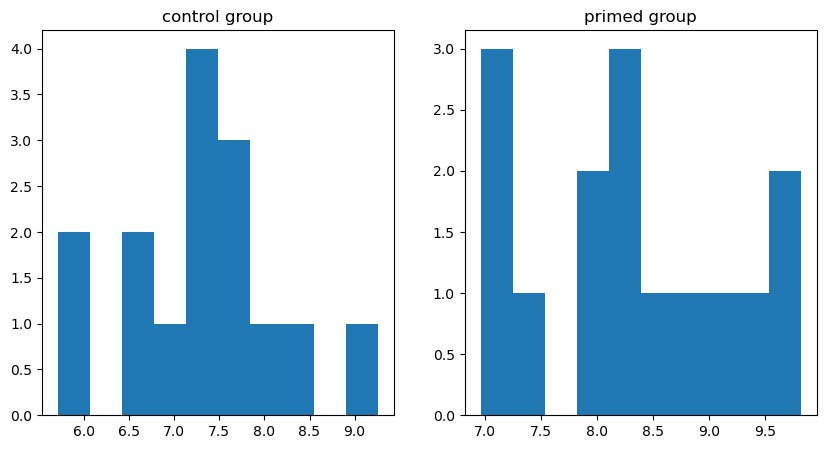

In [33]:
f,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(control_speed)
ax[0].set_title("control group")
ax[1].hist(primed_speed)
ax[1].set_title("primed group")

You might notice that this doesn't look very normally distributed after all. Like maybe its "roughly" normal. But there are a bunch of disprecancies too. We can really appreciate the problem if we plot the data side by side with some normal curves. I took some liberties with the plotting settings. But you can play around with them.

Text(0.5, 1.0, 'primed group')

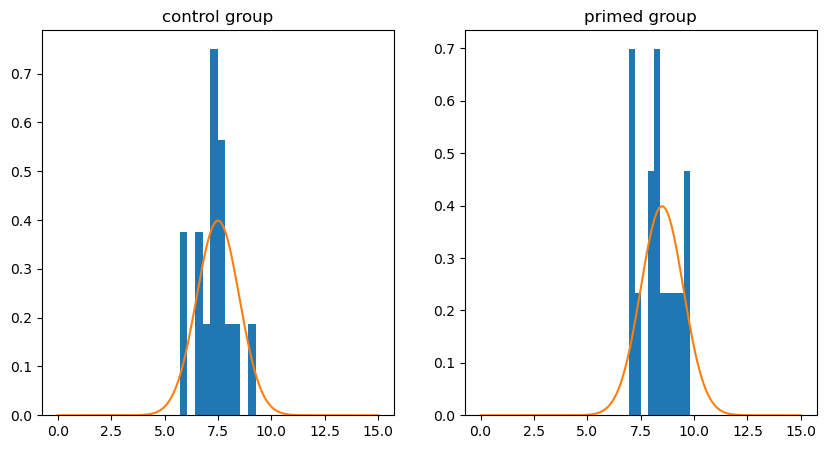

In [35]:
x = np.linspace(0,15,150)
y1 = stats.norm(7.5,1).pdf(x)
y2 = stats.norm(8.5,1).pdf(x)

f,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(control_speed,density=True)
ax[0].plot(x,y1)
ax[0].set_title("control group")
ax[1].hist(primed_speed,density=True)
ax[1].plot(x,y2)
ax[1].set_title("primed group")

You can see that in both cases, there are a few too many people in some parts of the distribution and not enough in another part. So it's not clear in what sense the data are normally distributed.

Here's how to clear up the mystery. Asserting something is normally distributed is a theoretical claim about the kinds of *causes* that lead to the data. It's about processes. The particular set of data you see is only a partial set of traces leftover by the process. Sometimes it will look bell-shaped and symmetrical. But sometimes not. Any finite dataset can be pretty far away from looking normal and still be well modelled by a normal distribution.

The big point is you cannot eyeball the histogram and figure out what kind of process produces the data. Instead you have to theorize. It's just like the lady tasting tea problem - we didn't decide it was a binomial process because of the way the data looked. We decided that by building models of the causal process that lead to tea tasting. Similarly, we cannot know how many mixture components to put in the model just by looking at the data. We have to theorize that as well.

## Why are normal distributions normal?

Okay so what kinds of causal processes produce normal distributions? Suppose you had 100 people stand in the middle of a football field. Over the course of several rounds, you have each person flips a coin to decides to take one step forward or one step backward. If you give the people enough rounds, they'll eventually settle into a normal distribution around the middle of the football field.

Let's build a simulation to show that. Our strategy will be to create 100 artificial people, give them a location and then repeat the stepping process a thousand times.

In [36]:
import numpy as np

# build 100 people at position zero

agents = [0] * 100

# take each agent in the list
# and step it forward or backward

for i in range(100):
    agents[i] = agents[i] + np.random.choice([-1,1])

The above code is like having everyone take a single step. We want them to take a 1000 steps. So we'll need a nested loop.

In [37]:
agents = [0] * 100

for j in range(1000):
    for i in range(100):
        agents[i] = agents[i] + np.random.choice([-1,1])

Now let's visualize the results.

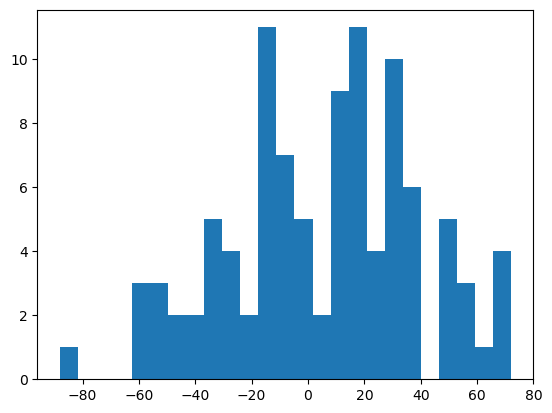

In [38]:
agents = [0] * 100

for j in range(1000):
    for i in range(100):
        agents[i] = agents[i] + np.random.choice([-1,1])

plt.hist(agents,bins=25)

It looks kinda normally distributed, kinda not. Much like our walkers. Let's tinker with parameters until we can get a smoother shape. Try it on your own first to build some intuitions about what each feature does to effect the shape. If we push the population size up and increase the number of histogram bins, it does a lot to smooth out the process.

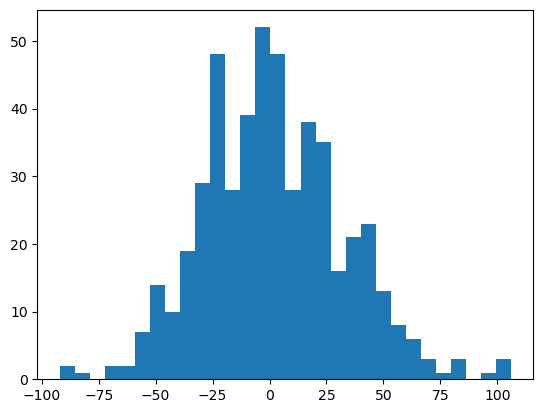

In [39]:
agents = [0] * 500

for j in range(1000):
    for i in range(500):
        agents[i] = agents[i] + np.random.choice([-1,1])

plt.hist(agents,bins=30)

Our model provides some insights into why normal distributions are common. Many traits are shaped by processes just like this. There must be some baseline height for the human species. Then some genetic factors add more height and other genetic factors take away height. The same goes for social and development factors. Grades also tend to be normally distributed. There must be some baseline grade and different factors add and subtract from that baseline. Or, walking speeds. There is some typical walking speed but then there are factors that make you a little bit slower and a little bit fast, like being late for class or being sleepy. 

This is one of the simplest causal models you could have. Whatever you outcome is, you imagine it's generated by two factors. Some central baseline and some set of factors that additively increase or decrease that outcome. 

# How to make and break a normal distribution

We now have an interesting argument for why we should expect many natural processes to generate normal distributions. But surely not everything should be normally distributed! There is a tendency in science to make generous use of normal distributions, even in cases where we don't have a very clear theory about what is going on. It's a kind of "when you have a hammer, everything looks like a nail" phenomena. We are used to fitting normal models and have good software for doing so. So that's the assumptions we make. But this gets the scientific process backward - we shouldn't assume real-world processes follow normal distributions because our software works. We should build theories about things because the theories make sense. The software should mend to our theories.

So now our question is: what kind of processes *don't* lead to normal distributions? Let's play with this simulation, adjusting the mechanisms until the resulting distribution looks very different.

I'm also going to adjust the code a little bit to make it faster and more flexible. Running big simulations like this might take a minute or two unless we optimize. So to make exploring easier, we'll use this cell.

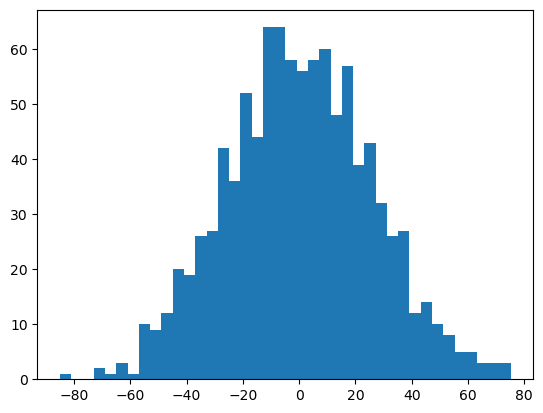

In [10]:
population_size = 1000
starting_position = 0 

agents = [starting_position] * population_size
agents = np.array(agents)

for j in range(2000):
    
    # the next line helps translate the parts of this vectorize model into english
    # agents = agents + direction * step size * continuousness variable    
    agents = agents + np.random.choice([-1,1],size=population_size) * 1 * np.random.random(size=population_size)

plt.hist(agents,bins=40)

This cell just exploits array computation. We have a long array that holds everyone's current position in it. Then we we pick a direction (backward or forward) with `np.random.choice([-1,1],size=population_size)`, we pick a step size `* 1` and we take a random proportion of the step size with `np.random.random(size=population_size)`. Everything happens 500 times or however big the population size is. This means that, instead of looping, we can just add giant arrays to each other in a single computation. That's what this line does.

`agents + np.random.choice([-1,1],size=population_size) * 1 * np.random.random(size=population_size)`

We are going to try a several techniques to break the normal distribution.

### What happens if I change the starting location?

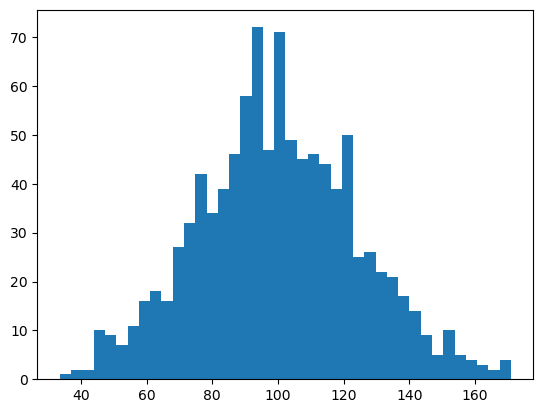

In [40]:
population_size = 1000
starting_position = 100 # adjusted here

agents = [starting_position] * population_size
agents = np.array(agents)

for j in range(2000):
    
    # direction * step size * continuousness variable    
    agents = agents + np.random.choice([-1,1],size=population_size) * 1 * np.random.random(size=population_size)

plt.hist(agents,bins=40)

It doesn't change the shape. It just changes where the center or mean of the distribution ends up. So if the baseline is 100, then you get a normal distribution spread around 100. This like adjusting the mean parameter.

### What happens if I change the step size?

It also doesn't change the shape. It just changes how spread out or standard deviation the distribution ends up. This is like adjusting the standard deviation parameter.

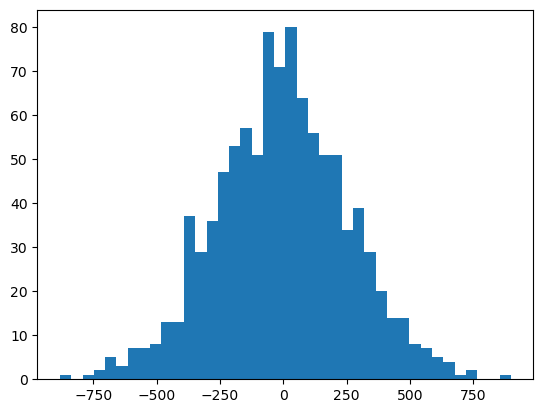

In [12]:
population_size = 1000
starting_position = 0

agents = [starting_position] * population_size
agents = np.array(agents)

for j in range(2000):
    
    # direction * step size * continuousness variable    
    agents = agents + np.random.choice([-1,1],size=population_size) * 10 * np.random.random(size=population_size)
    # changed 1 to 10

plt.hist(agents,bins=40)

### What happens if they take more backward steps than forward steps?

Surprisingly, this doesn't change the shape either. It just move the mean down a lot.

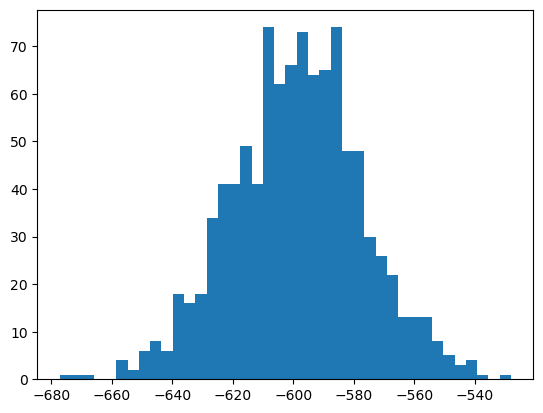

In [13]:
population_size = 1000
starting_position = 0

agents = [starting_position] * population_size
agents = np.array(agents)

for j in range(2000):
    
    # direction * step size * continuousness variable    
    agents = agents + np.random.choice([-1,1],p=[0.8,0.2],size=population_size) * 1 * np.random.random(size=population_size)
    # added the p=[0.8,0.2] argument to the np.random.choice() function
    
    
plt.hist(agents,bins=40)

There is a general lesson here: normal distributions are extremely resilient. You can tweak a bunch of assumptions they only push the parameters around. They do not structurally change the resulting distribution. We call this property robustness: small tweaks to our assumptions do not change the results.

This also explains why scientists feel comfortable assuming it. Things will often work out to be normal even if we get the assumptions a little bit off. It's an extremely generic model that works across a wide range of circumstances. But not every circumstance. Let's break it in two ways.

### What happens when people start in more than one place?

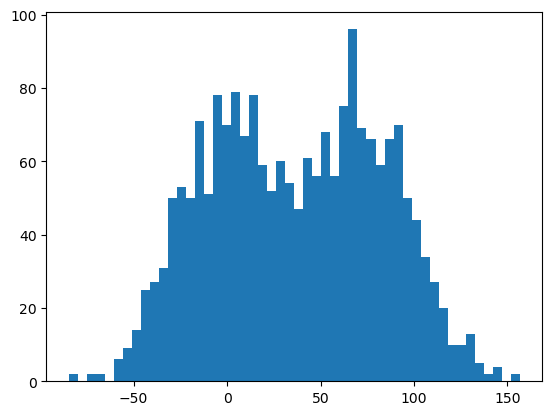

In [7]:
population_size = 2000
starting_position_1 = 0
starting_position_2 = 75

agents_1 = [starting_position_1] * (population_size // 2)
agents_2 = [starting_position_2] * (population_size // 2)
agents = agents_1 + agents_2
agents = np.array(agents)

for j in range(2000):
    
    # direction * step size * continuousness variable    
    agents = agents + np.random.choice([-1,1],size=population_size) * 1 * np.random.random(size=population_size)

plt.hist(agents,bins=50)
plt.show()

You can see that there are two peaks to this distribution. You've seen it before - a mixture. This makes good sense - people start in two different places so the distributions should fan out around those starting places. So normal distributions work when you suspect there is one baseline. They do not do as well we you expect there to be differences in the baselines. We've already see a realistic scientific problem where assuming two baselines seems good: heterogeneity in the Asch study. Some people are vulnerable to conformity. Others are not. Those are the two baselines. Around each baseline, we should expect some variation. Some vulnerable people will make more mistakes because of poor eyesight or a bit more extra peer pressure than usual.

### What happens when some agents can take bigger steps than others?

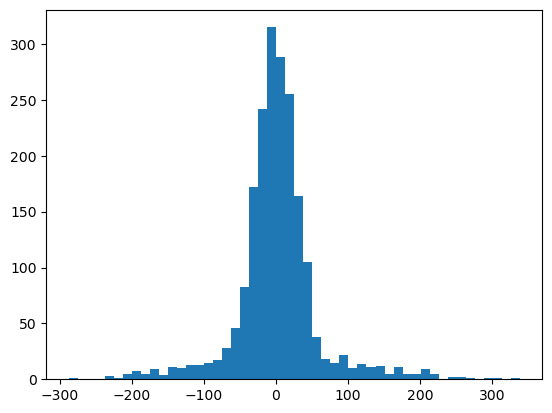

In [18]:
population_size = 2000
starting_position = 0

agents = [starting_position] * population_size
agents = np.array(agents)

for j in range(2000):
    
    # direction * step size * continuousness variable    
    agents_g1 = agents[:1500] + np.random.choice([-1,1],size=1500) * 1 * np.random.random(size=1500)
    agents_g2 = agents[1500:] + np.random.choice([-1,1],size=500) * 4 * np.random.random(size=500)
    agents = np.concatenate((agents_g1,agents_g2))

plt.hist(agents,bins=50)
plt.show()

I engineered this one so 1/4th of the people take steps 4 times larger than the other 3/4ths of the people. What you get is a distribution with "fat tails" or more spread than is typically possible according to the rules of normal distributions. This is another sort of heterogeneity where different participants in your study are subject to a lot more causes of variation that then others.

So two kinds of heterogeneity in normals: heterogeneity in starting points and heterogeneity in spread. We could build a mixture that represents this case - two normals with identical means at 0 but different variances. This type of mixture is so common that we have a special distribution for it - the Student's T distribution.

# Student's T distribution

We can access the student's T distribution with `stats.t()`. It has all the same methods as `stats.norm()`. It's parameters are 

    t(normality,mean,spread)
    
It ranges from 1-infinity. But after normality gets to be about 30, the distribution is essentially normal again. Here is what samples look like when `normality = 4`.

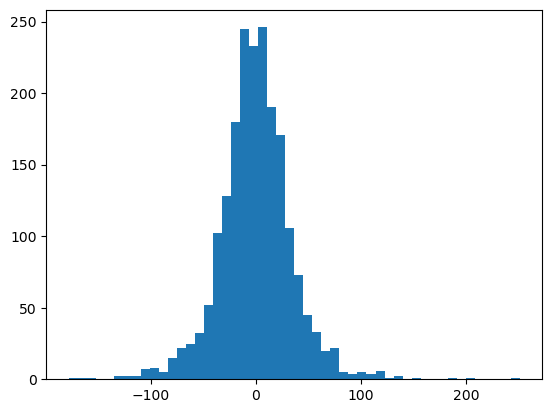

In [30]:
samples = stats.t(4,0,25).rvs(2000)
plt.hist(samples,bins=50);

You can get a feel for how all the parameters interact with these sliders. Nu is the popular abbreviation for normality.

In [33]:
import ipywidgets as widgets

def draw_t(nu,mean,std):
    
    x = np.linspace(-200,200,500)
    y = stats.t(nu,mean,std).pdf(x)
    y = y / sum(y)

    plt.plot(x,y)
    plt.ylim([0,0.05])

widgets.interact(draw_t,
                 nu=widgets.FloatSlider(min=1,max=60,step=0.01,value=30),
                 mean=widgets.FloatSlider(min=-200, max=200, step=0.01, value=0),
                 std=widgets.FloatSlider(min=0, max=20, step=0.01, value=15))

interactive(children=(FloatSlider(value=30.0, description='nu', max=60.0, min=1.0, step=0.01), FloatSlider(val…

<function __main__.draw_t(nu, mean, std)>

Now lets run a quick check to see whether there is likely to be hetereogeneity in our walking speeds dataset and whether that effects our estimate of the causal effect of behavioral priming. Most of the code is the same except we need one new prior and we need to swap our outcome distribution. For a prior on `nu` or normality, we'll use the same strategy as we did with the beta-binomial, picking an exponential prior where the mean is set to roughly the pace where `nu` stops making a difference. In this case, when `nu = 30` our distribution is regular normal again. Finally, we gotta add 1 because our distribution gets undefined if `nu` is less than 1.

In [30]:
with pm.Model() as m1:
    m0 = pm.Normal('mean_g0',10,5)
    m1 = pm.Normal('mean_g1',10,5)
    std = pm.Gamma('std',3,1) 
    nu = pm.Exponential('nu',1/30) + 1
    
    y0 = pm.StudentT('y0',nu=nu,mu=m0,sigma=std,observed=primed_speed)
    y1 = pm.StudentT('y1',nu=nu,mu=m1,sigma=std,observed=control_speed)
    trace1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_g0, mean_g1, std, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


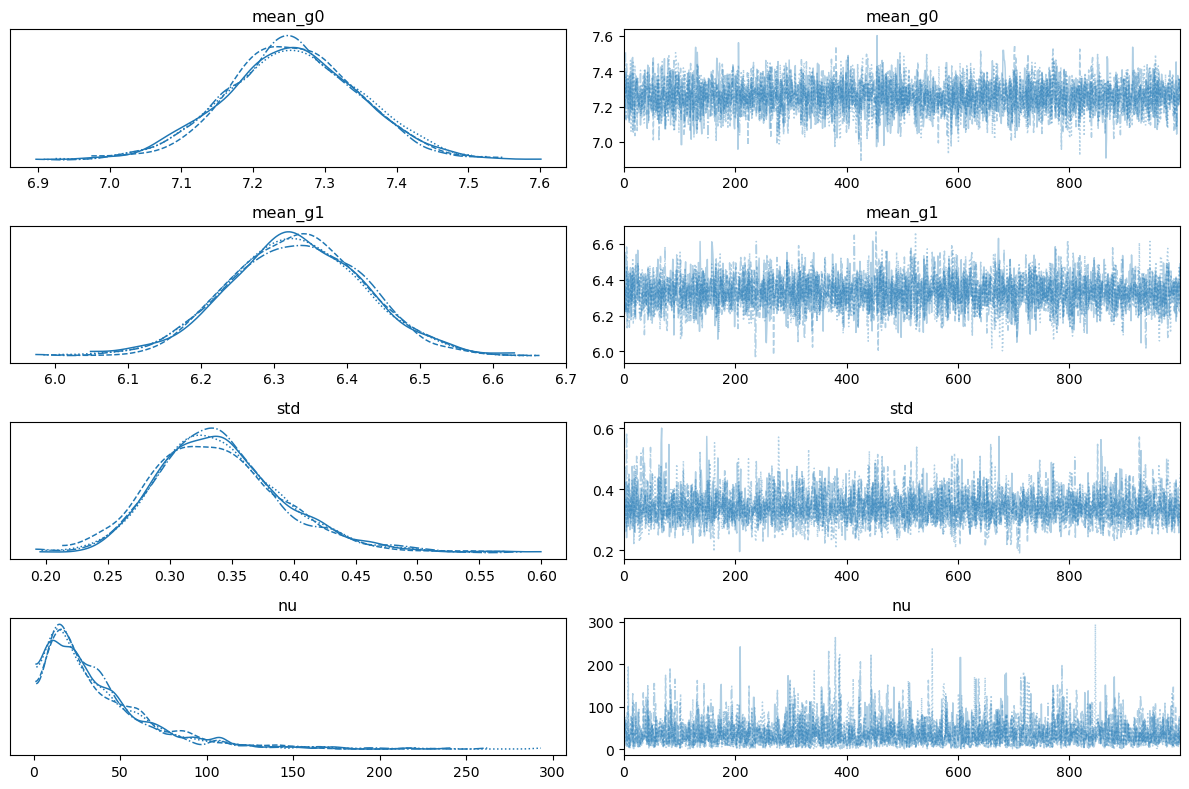

In [32]:
az.plot_trace(trace1)
plt.tight_layout()

First, notice that the mean and std didn't change. Even once we start searching for heterogeneity, they are uneffected. So that's a sign that assuming the absence of dispersion doesn't hurt much. Second, the mean of `nu` is a bit above 30. So that's a sign that our most plausible distribution would have little to no heterogeneity in it. Similar observations apply to the control group.

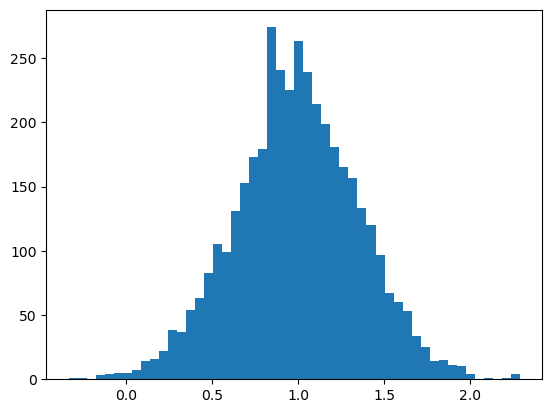

In [31]:
diffs = trace1.posterior['mean_g0'].values.flatten() - trace1.posterior['mean_g1'].values.flatten()
plt.hist(diffs,bins=50);

Finally, the posterior comparison on mean walking speed look the same too.

So what did we learn? Our inference about the causal effect of priming is robust with respect to heterogeneity. You can assume heterogeneity or ignore it. Either way, it looks like priming still decreases people's walking speed by about 1 second. This is the nice thing about building multiple models. You don't have to know exactly what the causal structure is. But if you have a few plausible guesses, you can just build all the models and compare them.

# How Bayesian inference can partition the causal effect from the noise and hetereogeneity

When I started this lecture, I noted that the statistical tools seem to be doing a kind of magic. They allow us to look at noisy data where there are loads of causes for variation and extract an estimate of a causal effect. How does this happen? Well it works in two steps:

1. We make assumptions about causes of noise to derive a distribution. If we think there is some baseline with random, additive sources of noise, then we end up with a normal. If we think there is something else going on, we might get a mixture or a Student's T distribution.

2. Then we estimate.

The estimation step involves systematically exploring possible relationships between noise and mean. The Monte Carlo Markov Chain algorithm tries out loads of combinations of parameters to figure out which ones are most consistent with the data and the priors. The resulting output is a kind of partitioning. We can extract a mean and an estimate of the noise from the data. With the estimates in hand, then we talk about what the most likely causal effect is. It's a completely remarkable strategy.